## STATS 601 Project workspace

### Import Libraries
Note that pandas version has to be 1.4.x or higher and python version has to be 3.8.x or higher in order to read the pickle file.

In [1]:
!pip3 install numpy==1.22.1
!pip3 install pandas==1.4.1
!pip3 install matplotlib
!pip3 install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=c4ad60d865459249f9be607f052aac25505d1a2c663de883df1d7b502be74492
  Stored in directory: \\engin-labs.m.storage.umich.edu\tywwyt\windat.v2\appdata\local\pip\cache\wheels\9b\13\01\6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn


In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

# !pip3 install bayesian-optimization
# import hyperparam
import critic

### Read data from pickle file and visualize
*log_pr* is the log prices of the ten assets in the past 6 months. *volu* is the trading volume of the ten assets in the past 6 months. 

In [2]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

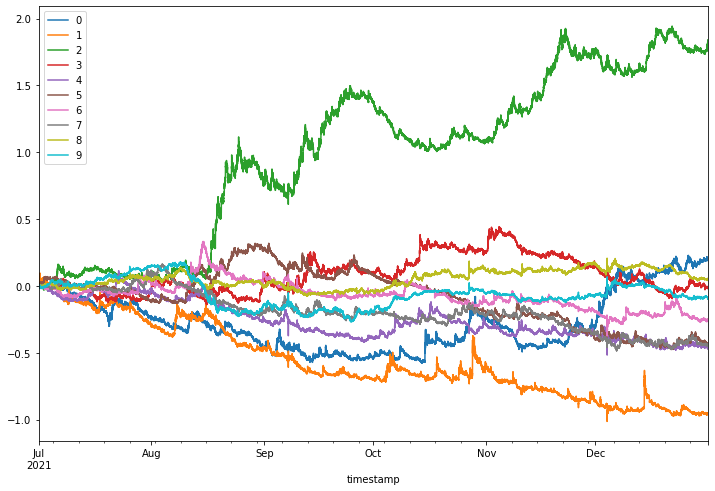

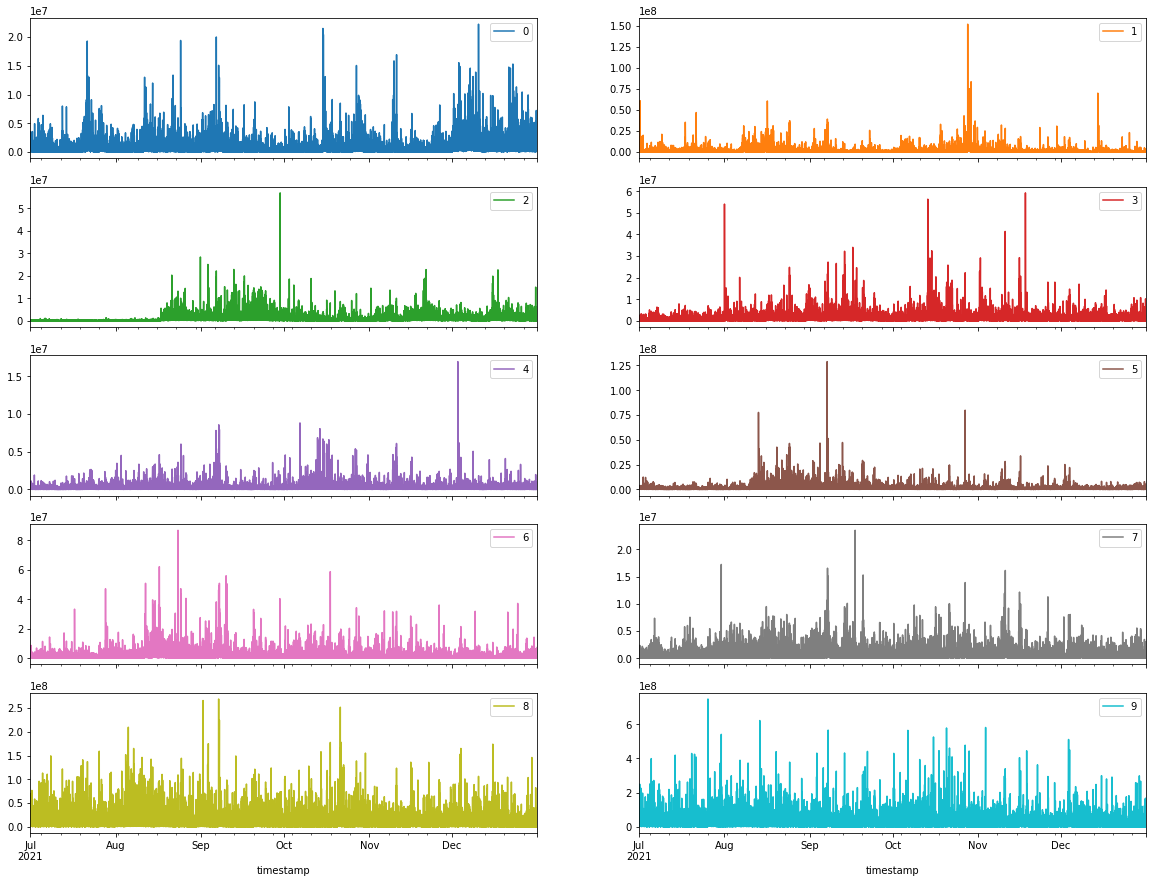

In [3]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))

# Check the volumes of the 10 assets

fig, axes = plt.subplots(5, 2, sharex=True, figsize=(20, 15))
volu.plot(subplots=True, ax=axes)

#TYWW starts here, 

In [4]:
log_pr_ind_np = np.zeros((10, log_pr.shape[0] // 1440 - 1, 1440))
volume_ind_np = np.zeros((10, log_pr.shape[0] // 1440 - 1, 1440))
for i in range(10):
    log_pr_ind_np[i] = np.delete(
        log_pr[i].to_numpy().reshape(log_pr.shape[0] // 1440, 1440), -1, 0)
    volume_ind_np[i] = np.delete(
        volu[i].to_numpy().reshape(volu.shape[0] // 1440, 1440), -1, 0)

log_pr_ind_np = np.moveaxis(log_pr_ind_np, 0, 1) # (num samples, features, 10)
volume_ind_np = np.moveaxis(volume_ind_np, 0, 1)

log_return_np = (log_pr.shift(-30) - log_pr).iloc[1440:-30:1440].to_numpy()  # (num samples, 10)

In [5]:
import ojsim
sim = ojsim.OJSimulator()
X,y = sim.formulized_train
X.shape, y.shape

((17709, 2, 1440, 10), (17709, 10))

In [6]:
A0 = X[:,:,:,0]
A0_pr = A0[:,0,:]
A0_vo = A0[:,1,:]

In [7]:
#close  - open
feature  = A0_pr[:,-1] - A0_pr[:,0]

In [10]:
#volumn log (#sample, 1:30)
np.log(A0_vo).shape
feature = np.concatenate((feature[:,None], np.log(A0_vo)[:,-30:]), axis = 1)
feature.shape

(17709, 31)

In [11]:
# difference vol (#sample, 31:60)
diff_vol_step = 30
diff_vol = A0_vo[:,diff_vol_step:] - A0_vo[:,:-diff_vol_step]
feature = np.append(feature, diff_vol[:,-30:], axis = 1)
feature.shape

(17709, 61)

In [12]:
#rate of change (#sample, 61:90)
df_vo = pd.DataFrame(A0_vo.T)
pct_chg_fxn = lambda x: x.pct_change()
# df_vo.apply(pct_chg_fxn).T.to_numpy()[:,1:].shape
feature = np.append(feature,df_vo.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
feature.shape

(17709, 91)

In [11]:
#moving avg
# ma_3 = lambda x: x.rolling(3).mean()
# feature = np.append(feature,(df_vo.apply(ma_3).apply(np.log).to_numpy()), axis = 1)

In [13]:
#moving avg (#sample,91:120)
avg_step = 30
ma_30 = lambda x: x.rolling(avg_step).mean()
df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
feature.shape

(17709, 121)

In [13]:
# ma_90 = lambda x: x.rolling(90).mean()
# feature = np.append(feature,(df_vo.apply(ma_90).apply(np.log).to_numpy()), axis = 1)

In [14]:
#z_score (#sample, 121:150)
z_score_min_period = 20
df_pr = pd.DataFrame(A0_pr)
zscore_fxn = lambda x: (x - x.mean()) / x.std()
zscore_fun_improved =lambda x: (x - x.rolling(window=200, min_periods=z_score_min_period).mean())/ x.rolling(window=200, min_periods=z_score_min_period).std()
df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,z_score_min_period-1:]
feature = np.append(feature,df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,-30:], axis = 1)
feature.shape

(17709, 151)

In [15]:
#df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,19:]

In [25]:
#percentile (#sample, 1448)
#rollrank_fxn = lambda x: x.rolling(window=200,min_periods=20).apply(lambda y: y.rank(pct=True).to_numpy()[0])
# import time
# t0 = time.time()
# rollrank_fxn = lambda x: x.rolling(200,min_periods=20).apply(lambda y: y.rank(pct=True).to_numpy()[0])
# percentile = df_vo.iloc[[0],:].apply(rollrank_fxn)
# print(time.time() - t0)
#percentile

# feature = np.append(feature,percentile, axis = 1)
# feature.shape

3.541290760040283


In [26]:
# 17709*3.54/3600

17.41385

In [18]:
#df_vo.shape

(1440, 17709)

In [16]:
#binning (#sample, 151:180)
n_bins = 10
bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
binning = df_vo.apply(bin_fxn).T
feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
feature.shape

(17709, 181)

In [17]:
#sign (#sample, 181:210)
feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
feature.shape
#(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,1:]

(17709, 211)

In [20]:
#plus-minus (#sample, 10001:11440)
plus_minus_fxn = lambda x: x.rolling(20).sum()
(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T.shape
feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
feature.shape

(17709, 241)

In [25]:
def func(A):
    return np.ones((2,2))

a = np.zeros((4,2))
np.apply_along_axis(func, 1, a)

array([[[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]]])

In [79]:
def feature_extract(A):
    A0_pr = A[:1440]
    A0_vo = A[1440:]
    #close  - open
    feature  = A0_pr[-1] - A0_pr[0]
    #volumn log (#sample, 1:30)
    feature = np.concatenate((np.array([feature]), np.log(A0_vo)[-30:]))
    # difference vol (#sample, 31:60)
    diff_vol_step = 30
    diff_vol = A0_vo[diff_vol_step:] - A0_vo[:-diff_vol_step]
    feature = np.append(feature, diff_vol[-30:])
    #rate of change (#sample, 61:90)
    df_vo = pd.DataFrame(A0_vo)
#     pct_chg_fxn = lambda x: x.pct_change()
#     feature = np.append(feature,df_vo.apply(pct_chg_fxn).T.to_numpy()[:,-30:])
    #moving avg (#sample,91:120)
#     avg_step = 30
#     ma_30 = lambda x: x.rolling(avg_step).mean()
#     df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
#     feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:])
    # z_score (#sample, 121:150)
#     z_score_min_period = 20
#     df_pr = pd.DataFrame(A0_pr[:,None])
#     #zscore_fxn = lambda x: (x - x.mean()) / x.std()
#     zscore_fun_improved =lambda x: (x - x.rolling(window=200, min_periods=z_score_min_period).mean())/ x.rolling(window=200, min_periods=z_score_min_period).std()
# #     df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,z_score_min_period-1:]
#     feature = np.append(feature,df_pr.apply(zscore_fun_improved).T.to_numpy()[:,-30:])
    #binning (#sample, 151:180)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    print("before apply")
    binning = df_vo.apply(bin_fxn).T
    print(binning.shape)
    feature = np.append(feature,binning.to_numpy()[:,-30:])

    return feature

input = np.concatenate((A0[:,0,:], A0[:,1,:]), axis = 1)  
#np.apply_along_axis(feature_extract, 1, input).shape
result = map(lambda x: feature_extract(x), input)

before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before appl

(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
b

before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before apply
(1, 1440)
before appl

KeyboardInterrupt: 

In [103]:
def FeatureExtract(A):
    A0_pr = A[:,:1440]
    A0_vo = A[:,1440:]
    feature  = A0_pr[:,-1] - A0_pr[:,0]
    # volumn log
    np.log(A0_vo).shape
    feature = np.concatenate((feature[:,None], np.log(A0_vo)[:,-30:]), axis = 1)
    # difference vol (#sample, 31:60)
    diff_vol_step = 30
    diff_vol = A0_vo[:,diff_vol_step:] - A0_vo[:,:-diff_vol_step]
    feature = np.append(feature, diff_vol[:,-30:], axis = 1)
    #rate of change (#sample, 61:90)
    df_vo = pd.DataFrame(A0_vo.T)
    pct_chg_fxn = lambda x: x.pct_change()
    feature = np.append(feature,df_vo.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    #moving avg (#sample,91:120)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
    feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
    #z_score (#sample, 121:150)
    z_score_min_period = 20
    df_pr = pd.DataFrame(A0_pr)
    zscore_fxn = lambda x: (x - x.mean()) / x.std()
    zscore_fun_improved =lambda x: (x - x.rolling(window=200, min_periods=z_score_min_period).mean())/ x.rolling(window=200, min_periods=z_score_min_period).std()
    df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,z_score_min_period-1:]
    feature = np.append(feature,df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,-30:], axis = 1)
    #binning (#sample, 151:180)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_vo.apply(bin_fxn).T
    feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
    #sign (#sample, 181:210)
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    #plus-minus (#sample, 10001:11440)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    (df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T.shape
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    return feature
    
    
    
import time
 
#input = np.concatenate((A0[:,0,:], A0[:,1,:]), axis = 1)  
input=np.random.normal(0,1,(17000,2880))
tic = time.perf_counter()
print(FeatureExtract(input).shape)
toc = time.perf_counter()
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

C:\Users\TYWWYT\AppData\Local\Temp\ipykernel_8656\3211759929.py:6: RuntimeWarning: invalid value encountered in log
  np.log(A0_vo).shape
C:\Users\TYWWYT\AppData\Local\Temp\ipykernel_8656\3211759929.py:7: RuntimeWarning: invalid value encountered in log
  feature = np.concatenate((feature[:,None], np.log(A0_vo)[:,-30:]), axis = 1)


(17000, 241)
Downloaded the tutorial in 66.6825 seconds


In [98]:
import ojsim
sim = ojsim.OJSimulator()
X,y = sim.formulized_train
X.shape, y.shape


((17709, 2, 1440, 10), (17709, 10))

#  feature selection


In [113]:
asset_num = 0
Y_train = y[:,asset_num]
input = np.concatenate((X[:,0,:,asset_num], X[:,1,:,asset_num]), axis = 1)  
input.shape

(17709, 2880)

In [126]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X_train = AllFeatureExtract(input)
Y_train = y[:,asset_num]



PR difference [[-0.00170035 -0.00226491 -0.0040568  ...  0.00029488 -0.00100732
  -0.00161351]
 [-0.00685941 -0.00675955 -0.00619363 ...  0.00046686  0.00157547
   0.00158865]
 [-0.00638604 -0.0052041  -0.00575174 ... -0.0046475  -0.00247486
  -0.00265506]
 ...
 [-0.00640003 -0.00639876 -0.00668572 ...  0.00142919  0.00263319
   0.00274257]
 [-0.00325153  0.00058431  0.00018066 ...  0.00951844  0.00760631
   0.00844691]
 [ 0.00671155  0.00617164  0.00517278 ...  0.00652522  0.00293263
   0.00040449]]
PR rate of change [[ 0.00405116  0.09229827 -0.00011689 ... -0.05511403  0.02947957
   0.04445253]
 [ 0.01373255  0.00860386 -0.04477341 ...  0.06137227 -0.06496564
  -0.02803981]
 [ 0.03300576  0.00359173  0.08571357 ...  0.02880154 -0.08824502
   0.01526047]
 ...
 [ 0.00042407 -0.00431227  0.00514398 ... -0.00205514 -0.0065513
   0.00119434]
 [ 0.00090036 -0.00919091  0.00255759 ... -0.00182583  0.00161879
  -0.00104076]
 [ 0.0045019   0.00373266 -0.00167959 ...  0.00191125  0.00543954
 

In [127]:
pd.DataFrame(X_train.T).dropna().shape

(421, 17709)

In [128]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,f_regression
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, Y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
print( X_train_fs, fs)


[[-0.013236348716118507 11.930004910783131 11.748510520399092 ... -1.0
  1.0 1.0]
 [-0.01196175496072981 11.297375966953432 13.053418019074323 ... 1.0 -1.0
  -1.0]
 [-0.01399635923857356 12.928459633283396 12.652502429179172 ... 1.0 -1.0
  1.0]
 ...
 [-0.029537404754142044 11.79642844566988 12.265544929307143 ... -1.0
  -1.0 1.0]
 [-0.023345929287381162 11.123810872176158 11.802315647770564 ... -1.0
  1.0 -1.0]
 [-0.026138226765297895 11.105609679915425 11.24005825122513 ... 1.0 1.0
  1.0]] SelectKBest(k='all', score_func=<function f_regression at 0x00000233461AF550>)


Feature 0: 25.576889
Feature 1: 296.838746
Feature 2: 280.930946
Feature 3: 287.230796
Feature 4: 328.850910
Feature 5: 367.357767
Feature 6: 242.372105
Feature 7: 321.490466
Feature 8: 271.519649
Feature 9: 368.692777
Feature 10: 318.627512
Feature 11: 297.601585
Feature 12: 282.282836
Feature 13: 288.231221
Feature 14: 329.190493
Feature 15: 367.551254
Feature 16: 243.237737
Feature 17: 322.614124
Feature 18: 273.045558
Feature 19: 370.332372
Feature 20: 319.849218
Feature 21: 299.192807
Feature 22: 282.345785
Feature 23: 287.931264
Feature 24: 329.381983
Feature 25: 368.499583
Feature 26: 243.004982
Feature 27: 322.665515
Feature 28: 273.260507
Feature 29: 370.929471
Feature 30: 320.034892
Feature 31: 0.000367
Feature 32: 0.001179
Feature 33: 0.001545
Feature 34: 0.002181
Feature 35: 0.000894
Feature 36: 0.004130
Feature 37: 0.004344
Feature 38: 0.000510
Feature 39: 0.000205
Feature 40: 0.000002
Feature 41: 0.006617
Feature 42: 0.001816
Feature 43: 0.003084
Feature 44: 0.000910
Feat

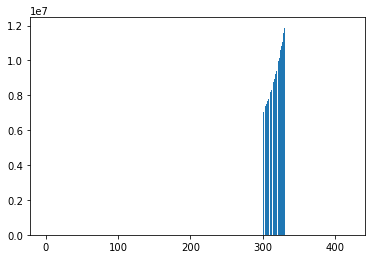

In [129]:
import matplotlib
import matplotlib.pyplot as plt
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

[[-0.013236348716118507 11.930004910783131 11.748510520399092 ... -1.0
  1.0 1.0]
 [-0.01196175496072981 11.297375966953432 13.053418019074323 ... 1.0 -1.0
  -1.0]
 [-0.01399635923857356 12.928459633283396 12.652502429179172 ... 1.0 -1.0
  1.0]
 ...
 [-0.029537404754142044 11.79642844566988 12.265544929307143 ... -1.0
  -1.0 1.0]
 [-0.023345929287381162 11.123810872176158 11.802315647770564 ... -1.0
  1.0 -1.0]
 [-0.026138226765297895 11.105609679915425 11.24005825122513 ... 1.0 1.0
  1.0]] SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000002333A21D430>)
Feature 0: 0.443371
Feature 1: 0.100810
Feature 2: 0.108152
Feature 3: 0.108548
Feature 4: 0.100123
Feature 5: 0.108307
Feature 6: 0.089109
Feature 7: 0.110241
Feature 8: 0.103973
Feature 9: 0.104391
Feature 10: 0.098664
Feature 11: 0.112044
Feature 12: 0.110105
Feature 13: 0.124247
Feature 14: 0.100213
Feature 15: 0.105009
Feature 16: 0.098817
Feature 17: 0.115729
Feature 18: 0.096370
Feature 19: 0.

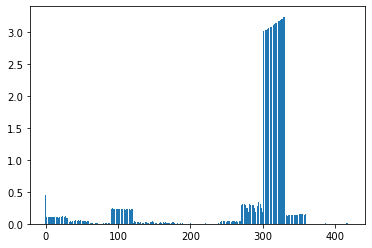

In [130]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_regression
# configure to select all features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train, Y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
print( X_train_fs, fs)
import matplotlib
import matplotlib.pyplot as plt
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()
    

In [125]:
def AllFeatureExtract(A):
    A0_pr = A[:,:1440]
    A0_vo = A[:,1440:]
    feature  = A0_pr[:,-1] - A0_pr[:,0]
    #VO volumn log
    np.log(A0_vo).shape
    feature = np.concatenate((feature[:,None], np.log(A0_vo)[:,-30:]), axis = 1)
    #VO difference vol (#sample, 31:60)
    diff_vol_step = 30
    diff_vol = A0_vo[:,diff_vol_step:] - A0_vo[:,:-diff_vol_step]
    feature = np.append(feature, diff_vol[:,-30:], axis = 1)
    #VO rate of change (#sample, 61:90)
    df_vo = pd.DataFrame(A0_vo.T)
    pct_chg_fxn = lambda x: x.pct_change()
    feature = np.append(feature,df_vo.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    #VO moving avg (#sample,91:120)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
    feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
    #PR z_score (#sample, 121:150)
    z_score_min_period = 20
    df_pr = pd.DataFrame(A0_pr)
    zscore_fxn = lambda x: (x - x.mean()) / x.std()
    zscore_fun_improved =lambda x: (x - x.rolling(window=200, min_periods=z_score_min_period).mean())/ x.rolling(window=200, min_periods=z_score_min_period).std()
    df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,z_score_min_period-1:]
    feature = np.append(feature,df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,-30:], axis = 1)
    #VO binning (#sample, 151:180)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_vo.apply(bin_fxn).T
    feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
    #VO sign (#sample, 181:210)
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    #VO plus-minus (#sample, 211:240)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    (df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T.shape
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    
    #PR difference (#sample, 241:270)
    diff_pr_step = 30
    diff_pr = A0_pr[:,diff_vol_step:] - A0_pr[:,:-diff_vol_step]
    print("PR difference", A0_pr[:,diff_vol_step:] - A0_pr[:,:-diff_vol_step])
    feature = np.append(feature, diff_pr[:,-30:], axis = 1)
    #PR rate of change (#sample, 271:300)
    df_pr = pd.DataFrame(A0_pr.T)
    pct_chg_fxn = lambda x: x.pct_change()
    print("PR rate of change", df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    #PR moving avg (#sample,301:330)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_pr.apply(ma_30).T.to_numpy()[:,avg_step-1:]
    print("PR moving avg", df_pr.apply(ma_30).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(ma_30).T.to_numpy()[:,-30:], axis = 1) 
    #PR binning (#sample, 331:360)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_pr.apply(bin_fxn).T
    print("PR binning", binning.to_numpy()[:,-30:])
    feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
    #PR sign (#sample, 361:390)
    print("PR sign", (df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:])
    feature = np.append(feature,(df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    #PR plus-minus (#sample, 391:420)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    print("PR plus-minus", (df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T)
    feature = np.append(feature,(df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    return feature
    
    

In [ ]:
def refined_features(A):
    A0_pr = A[:,:1440]
    A0_vo = A[:,1440:]
    diff_vol_step = 30
    diff_vol = A0_vo[:,diff_vol_step:] - A0_vo[:,:-diff_vol_step]
    feature = diff_vol[:,-30:]
    #VO moving avg (#sample,31:60)
    df_vo = pd.DataFrame(A0_vo.T)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
    feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
    #PR rate of change (#sample, 61:90)
    df_pr = pd.DataFrame(A0_pr.T)
    pct_chg_fxn = lambda x: x.pct_change()
    print("PR rate of change", df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    #PR moving avg (#sample,91:120)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_pr.apply(ma_30).T.to_numpy()[:,avg_step-1:]
    print("PR moving avg", df_pr.apply(ma_30).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(ma_30).T.to_numpy()[:,-30:], axis = 1) 
    #PR binning (#sample, 331:360)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_pr.apply(bin_fxn).T
    print("PR binning", binning.to_numpy()[:,-30:])
    feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
    
    return feature
    
    

In [173]:
A0_pr = np.random.normal(0, 1, (20,1440)) #abs(np.random.normal(0, 1, (20,1440)))+1
#A0_vo = abs(np.random.normal(0, 1, (20,1440)))+1
df_pr = pd.DataFrame(A0_pr[:,-59:].T)
avg_step = 30
ma_30 = lambda x: x.rolling(avg_step).mean()
df_pr.apply(ma_30).T.to_numpy()[:,avg_step-1:]
#print("PR moving avg", df_pr.apply(ma_30).T.to_numpy()[:,-30:])
feature,df_pr.apply(ma_30).T.to_numpy()[:,-30:]
    

(array([-0.013236348716118507, 11.930004910783131, 11.748510520399092, ...,
        10, 10, 5], dtype=object),
 array([[-2.50740876e-02, -2.99882313e-02,  1.14722684e-02,
         -2.94603160e-02, -3.42835896e-02,  4.82349641e-02,
          3.52064054e-02,  5.07356468e-02,  7.08042652e-02,
          4.65367884e-02,  6.18285051e-02,  1.27355360e-01,
          5.58738144e-02,  4.17519210e-02, -3.36380304e-02,
         -2.23627403e-02, -9.98942263e-03,  4.04249999e-02,
          1.06960117e-01,  1.23686001e-01,  1.82923662e-01,
          1.33477795e-01,  1.06015593e-01,  1.21220721e-01,
          1.15271377e-01,  1.08645608e-01,  9.34665491e-02,
          1.10905442e-01,  1.59217473e-01,  1.38029674e-01],
        [ 2.60406564e-01,  2.38039136e-01,  1.71885917e-01,
          2.38403132e-01,  2.46462957e-01,  2.41429856e-01,
          1.42303255e-01,  1.66177652e-01,  1.28289811e-01,
          1.44468577e-01,  1.44096349e-01,  2.51475099e-01,
          2.95582032e-01,  2.68293153e-01,  2.63

In [140]:
def FastAllFeatureExtract(A):
    A0_pr = A[:,:1440]
    A0_vo = A[:,1440:]+1
    feature  = A0_pr[:,-1] - A0_pr[:,0]
    #VO volumn log################
    feature = np.concatenate((feature[:,None], np.log(A0_vo[:,-30:])), axis = 1)
    
    #VO difference vol (#sample, 31:60)#####
    diff_vol_step = 30
    diff_vol = A0_vo[:,-diff_vol_step:] - A0_vo[:,-2*diff_vol_step:-diff_vol_step]
    feature = np.append(feature, diff_vol[:,-30:], axis = 1)
    
    #VO rate of change (#sample, 61:90)!
    df_vo = pd.DataFrame(A0_vo[:,-31:].T)
    pct_chg_fxn = lambda x: x.pct_change()
    feature = np.append(feature,df_vo.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    
    #VO moving avg (#sample,91:120)########
    avg_step = 30
    df_vo = pd.DataFrame(A0_vo[:,-59:].T)
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
    feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
    
    #PR z_score (#sample, 121:150)!
    df_pr = pd.DataFrame(A0_pr[:,-49:])
    z_score_min_period = 20
    df_pr = pd.DataFrame(A0_pr)
    zscore_fxn = lambda x: (x - x.mean()) / x.std()
    zscore_fun_improved =lambda x: (x - x.rolling(window=200, min_periods=z_score_min_period).mean())/ x.rolling(window=200, min_periods=z_score_min_period).std()
    df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,z_score_min_period-1:]
    feature = np.append(feature,df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,-30:], axis = 1)
    
    #VO binning (#sample, 151:180)!
    df_vo = pd.DataFrame(A0_vo[:,-30:].T)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_vo.apply(bin_fxn).T
    feature = np.append(feature,binning.to_numpy(), axis = 1)
    
    #VO sign (#sample, 181:210)!
    df_vo = pd.DataFrame(A0_vo[:,-31:].T)
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    
    #VO plus-minus (#sample, 211:240)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    (df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T.shape
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    
    #PR difference (#sample, 241:270)
    diff_pr_step = 30
    diff_pr = A0_pr[:,diff_vol_step:] - A0_pr[:,:-diff_vol_step]
    #print("PR difference", A0_pr[:,diff_vol_step:] - A0_pr[:,:-diff_vol_step])
    feature = np.append(feature, diff_pr[:,-30:], axis = 1)
    
    #PR rate of change (#sample, 271:300)#######
    df_pr = pd.DataFrame(A0_pr[:,-31:].T)
    pct_chg_fxn = lambda x: x.pct_change()
    #print("PR rate of change", df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    
    #PR moving avg (#sample,301:330)  #######
    df_pr = pd.DataFrame(A0_pr[:,-59:].T)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_pr.apply(ma_30).T.to_numpy()[:,avg_step-1:]
    #print("PR moving avg", df_pr.apply(ma_30).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(ma_30).T.to_numpy()[:,-30:], axis = 1) 
    
    #PR binning (#sample, 331:360)#########
    df_pr = pd.DataFrame(A0_pr[:,-30:].T)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_pr.apply(bin_fxn).T
    #print("PR binning", binning.to_numpy()[:,-30:])
    feature = np.append(feature,binning.to_numpy(), axis = 1)
    
    #PR sign (#sample, 361:390)
    #print("PR sign", (df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:])
    feature = np.append(feature,(df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    
    #PR plus-minus (#sample, 391:420)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    #print("PR plus-minus", (df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T)
    feature = np.append(feature,(df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    
    return feature

In [174]:
def FastAllFeatureExtract(A):
    A0_pr = A[:,:1440]
    A0_vo = A[:,1440:]+1
    feature  = A0_pr[:,-1] - A0_pr[:,0]
    #VO volumn log################
    feature = np.concatenate((feature[:,None], np.log(A0_vo[:,-30:])), axis = 1)
       
    #VO moving avg (#sample,91:120)########
    avg_step = 30
    df_vo = pd.DataFrame(A0_vo[:,-59:].T)
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
    feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
    
    #PR rate of change (#sample, 271:300)#######
    df_pr = pd.DataFrame(A0_pr[:,-31:].T)
    pct_chg_fxn = lambda x: x.pct_change()
    #print("PR rate of change", df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    
    #PR moving avg (#sample,301:330)  #######
    df_pr = pd.DataFrame(A0_pr[:,-59:].T)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_pr.apply(ma_30).T.to_numpy()[:,avg_step-1:]
    #print("PR moving avg", df_pr.apply(ma_30).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(ma_30).T.to_numpy()[:,-30:], axis = 1) 
    
    #PR binning (#sample, 331:360)#########
    df_pr = pd.DataFrame(A0_pr[:,-30:].T)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_pr.apply(bin_fxn).T
    #print("PR binning", binning.to_numpy()[:,-30:])
    feature = np.append(feature,binning.to_numpy(), axis = 1)
    
    return feature

In [175]:
import pickle
ass0 = pickle.load(open('LR0.plk', 'rb'))
ass1 = pickle.load(open('LR1.plk', 'rb'))
ass2 = pickle.load(open('LR2.plk', 'rb'))
ass3 = pickle.load(open('LR3.plk', 'rb'))
ass4 = pickle.load(open('LR4.plk', 'rb'))
ass5 = pickle.load(open('LR5.plk', 'rb'))
ass6 = pickle.load(open('LR6.plk', 'rb'))
ass7 = pickle.load(open('LR7.plk', 'rb'))
ass8 = pickle.load(open('LR8.plk', 'rb'))
ass9 = pickle.load(open('LR9.plk', 'rb'))

In [176]:
A = np.random.normal(0,1, (10,1440))
B = abs(np.random.normal(0,1, (10,1440)))
iin =np.concatenate((A,B), axis=1)

In [182]:
mid = FastAllFeatureExtract(iin)

In [193]:
mid[2,:31].shape

(31,)

In [219]:
in0 = mid[[0],:]
in1 = mid[[1],:]
diff_vol = B[[2],-30:] - B[[2],-60:-30]
in2 = np.concatenate((mid[[2],:31],diff_vol,mid[[2],31:121]),axis = 1)
in3 = mid[[3],:]
in4 = mid[[4],:]
in5 = mid[[5],:]
in6 = mid[[6],:]
in7 = mid[[7],list(range(0, 1))+ list(range(31, 151))][None,:]
in8 = mid[[8],list(range(0, 1))+ list(range(61, 151))][None,:]
in9 = mid[[9],list(range(0, 1))+ list(range(61, 151))][None,:]

In [231]:
def get_r_hat(A, B):
    A = A.values.T
    B = B.values.T
    iin =np.concatenate((A,B), axis=1)
    mid = FastAllFeatureExtract(iin)
    in0 = mid[[0],:]
    in1 = mid[[1],:]
    diff_vol = B[[2],-30:] - B[[2],-60:-30]
    in2 = np.concatenate((mid[[2],:31],diff_vol,mid[[2],31:121]),axis = 1)
    in3 = mid[[3],:]
    in4 = mid[[4],:]
    in5 = mid[[5],:]
    in6 = mid[[6],:]
    in7 = mid[[7],list(range(0, 1))+ list(range(31, 151))][None,:]
    in8 = mid[[8],list(range(0, 1))+ list(range(61, 151))][None,:]
    in9 = mid[[9],list(range(0, 1))+ list(range(61, 151))][None,:]

    return np.array([ass0.predict(in0)[0],ass1.predict(in1)[0],ass2.predict(in1)[0],\
         ass3.predict(in3)[0],ass4.predict(in4)[0],ass5.predict(in5)[0],\
          ass6.predict(in6)[0],ass7.predict(in7)[0],ass8.predict(in8)[0],\
         ass9.predict(in9)[0]]) - A[:,-1]

In [232]:
import ojsim
import main
sim = ojsim.OJSimulator()
sim.submit(get_r_hat)

Total time used: 209.305s
Pairwise correlation:
	asset 0 = -0.00579
	asset 1 = 0.03391
	asset 2 = -0.00076
	asset 3 = 0.00948
	asset 4 = 0.02482
	asset 5 = 0.03157
	asset 6 = -0.00147
	asset 7 = 0.01931
	asset 8 = -0.00733
	asset 9 = -0.02897
	mean correlation = 0.00748
Overall correlation: 0.00109
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [1]:
import ojsim
import main
sim = ojsim.OJSimulator()
sim.submit(main.get_r_hat)

Total time used: 206.660s
Pairwise correlation:
	asset 0 = -0.00579
	asset 1 = 0.03391
	asset 2 = -0.00076
	asset 3 = 0.00948
	asset 4 = 0.02482
	asset 5 = 0.03157
	asset 6 = -0.00147
	asset 7 = 0.01931
	asset 8 = -0.00733
	asset 9 = -0.02897
	mean correlation = 0.00748
Overall correlation: 0.00109
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)
